# EDA (Exploratory Data Analysis): 

This is a basic exploratory data analysis for categorical and numerical variables. It has been tested for these scikit-learn datasets:
- **iris**: numerical features, categorical target.
- **titanic**: numerical and categorical features, numerical target (nominal).
- **boston**: numerical features, numerical target.

In [1]:
%matplotlib inline
import os
import sys  
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/juan/miniconda3/envs/mltools/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### arguments

In [2]:
# import arguments
sys.path.append('../../arguments/')  
from _arguments_titanic import *
print('- folder input path:',folder_input_raw)
print('- file input name:',file_input_raw)
print('- target variable name:',starget)
# import reader
sys.path.append('../../scripts/tools')  
from reader import csv2df as reader

- folder input path: /Users/juan/Workspace/Data/dataset-titanic
- file input name: train.csv
- target variable name: Survived


### read data

In [3]:
path = os.path.join(folder_input_raw,file_input_raw)
dfdata,dcol = reader(path,starget=starget)

In [4]:
# available variables
print('Column names:')
print('- target(%s): %s'%(len(dcol['ly']),dcol['ly']))
print('- features(%s): %s'%(len(dcol['lx']),dcol['lx']))
print('- float(%s): %s'%(len(dcol['lc_float']),dcol['lc_float']))
print('- int(%s): %s'%(len(dcol['lc_int']),dcol['lc_int']))
print('- cat(%s): %s'%(len(dcol['lc_cat']),dcol['lc_cat']))

Column names:
- target(1): ['y']
- features(11): ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
- float(2): ['Age', 'Fare']
- int(5): ['PassengerId', 'y', 'Pclass', 'SibSp', 'Parch']
- cat(5): ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


## BASIC STATISTICS

In [5]:
## display tables with basic stastistics 
def dfdescribe(df:'dataframe'):
    """
    Display tables with basic stastistics for categorical and numeracila data.
    df -- df of data.
    """
    from IPython.display import display, HTML
    import pandas as pd

    # list of columns per type
    lcol_num = list(df.select_dtypes(include=['float64','int64']).columns.values)
    lcol_cat = list(df.select_dtypes(include=['object']).columns.values)
    
    # header
    display(HTML('<h1>BASIC STATISTICS:</h1>'))
    display(HTML(df.info()))
    ## basic statistics: numerical data
    display(HTML('<h2>Numerical Data</h2>'))
    display(HTML(pd.concat([df.describe().transpose(),
            pd.DataFrame(df.isnull().sum(),columns=['nnull']),
            pd.DataFrame(df.dtypes,columns=['dtypes'])],axis=1).dropna().to_html())) 
    # if there are categorical variables
    if len(lcol_cat)>0:    
        ## basic statistics: categorical variables
        display(HTML('<h2>Categorical Data</h2>'))
        display(HTML(pd.concat([df.describe(include=['O', 'category']).transpose(),
                pd.DataFrame(df.isnull().sum(),columns=['nnull']),
                pd.DataFrame(df.dtypes,columns=['dtypes'])],axis=1).dropna().to_html()))
        # frequencies
        for icol in lcol_cat:
            display(HTML('<h3>- Categorical Variable: "%s"</h3>'%icol))
            display(HTML(pd.concat([pd.DataFrame(df[icol].value_counts()).rename(columns={icol:'%s(%s)'%(icol,'num')}),  
                      pd.DataFrame(df[icol].value_counts()*100./float(len(df))).rename(columns={icol:'%s(%s)'%(icol,'%')})],axis=1).sort_values(['%s(%s)'%(icol,'%')], ascending=[0]).head(10).to_html()))
        ## basic statistics: categorical vs numerical variables
        if len(lcol_cat)>1 and len(lcol_num):
            display(HTML('<h2>Categorical vs Numerical Variables</h2>'))
            for scol_cat in lcol_cat:
                for scol_num in lcol_num:
                    dfgrouped = df.groupby(scol_cat)[scol_num].describe().sort_values(['count'], ascending=[0]).dropna()
                    if len(dfgrouped)>0:
                        display(HTML('<h3>- [Cat.: "%s"] vs [Num.: "%s"]</h3>'%(scol_cat,scol_num)))
                        display(HTML(dfgrouped.sort_index().head(10).to_html()))  
    ## basic statistics: correlation matrix (between num. variables)
    display(HTML('<h2>Matrix Correlation (for Num. Variables)</h2>'))
    display(HTML(df.corr().to_html()))
    # return
    return None

In [6]:
dfdescribe(dfdata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
y              891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


<IPython.core.display.HTML object>

## BOXPLOTS

In [7]:
## display boxplots
def dfboxplot(df:'dataframe')->dict:
    """
    Display boxplots for categorical and numeracila data.
    df -- df of data.
    return -- dictionary with possible outliers.
    """
    from IPython.display import display, HTML

    # list of columns per type
    lcol_num = list(df.select_dtypes(include=['float64','int64']).columns.values)
    lcol_cat = list(df.select_dtypes(include=['object']).columns.values)
    
    ## boxplot: numerical variables
    display(HTML('<h2>Boxplot: Numerical Data</h2>'))
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    _, bp = df[lcol_num].boxplot(rot=90,fontsize=12,grid=True,ax=ax,return_type='both')
    plt.show()
    # collect outlier
    doutliers = dict()
    loutliers = [flier.get_ydata() for flier in bp["fliers"]]
    for scol,outliers in zip(lcol_num,loutliers):
        if len(outliers)>0: 
            doutliers[scol] = outliers
            display(HTML('<b>Warning</b>: variable "%s" has %s possible outliers.'%(scol,len(outliers))))   
    # if there are categorical variables
    if len(lcol_cat)>0:    
        ## boxplot: categorical vs numerical variables      
        display(HTML('<h2>Boxplot: Categorical vs Numerical Data</h2>'))
        for scol_cat in lcol_cat:
            if len(df[scol_cat].unique())<=24:
                display(HTML('<h3>- Cat. Variable: "%s"</h3>'%(scol_cat)))
                import matplotlib.pyplot as plt
                fig, ax = plt.subplots(figsize=(10,10))
                df.boxplot(rot=90,fontsize=12,grid=True,ax=ax,by=scol_cat)
                plt.show()
    # return 
    return doutliers

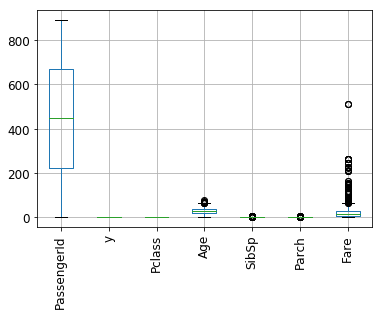

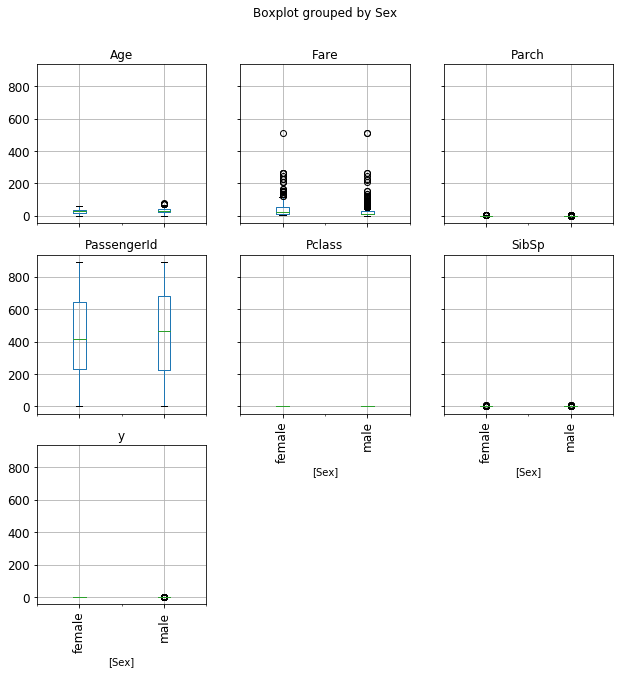

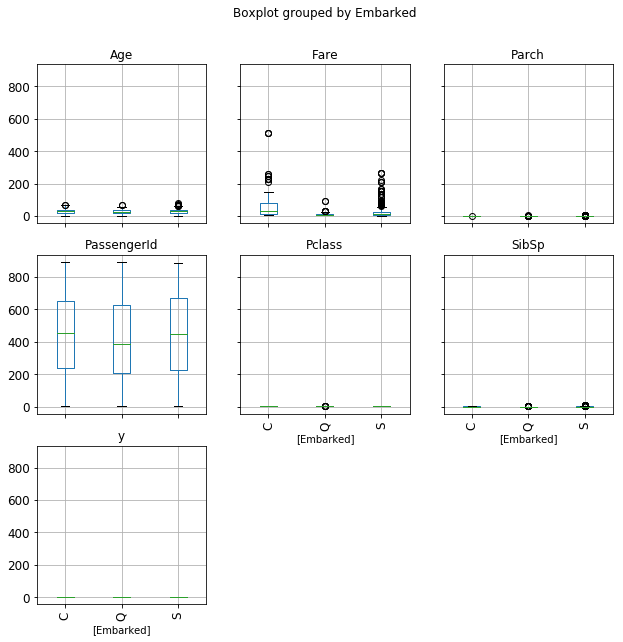

{'Age': array([66. , 65. , 71. , 70.5, 65. , 65. , 71. , 80. , 70. , 70. , 74. ]),
 'SibSp': array([3., 4., 3., 3., 4., 5., 3., 4., 5., 3., 3., 4., 8., 4., 4., 3., 8.,
        4., 8., 3., 4., 4., 4., 4., 8., 3., 3., 5., 3., 5., 3., 4., 4., 3.,
        3., 5., 4., 3., 4., 8., 4., 3., 4., 8., 4., 8.]),
 'Parch': array([1., 2., 1., 5., 1., 1., 5., 2., 2., 1., 1., 2., 2., 2., 1., 2., 2.,
        2., 3., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2., 2., 1., 2., 2., 2.,
        1., 2., 1., 1., 2., 1., 4., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 2., 2., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1.,
        1., 1., 1., 2., 1., 2., 2., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1.,
        2., 1., 1., 1., 4., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2.,
        1., 1., 2., 2., 3., 4., 1., 2., 1., 1., 2., 1., 2., 1., 2., 1., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 4.,
        1., 1., 2., 1., 2., 1., 1., 2., 5., 2., 1., 1., 1., 2., 1., 5., 2.,
     

In [8]:
dfboxplot(dfdata)

## HISTOGRAMS

In [9]:
## display histograms
def dfhist(df:'dataframe'):
    """
    Display histograms for categorical and numeracila data.
    df -- df of data.
    """
    from IPython.display import display, HTML

    # list of columns per type
    lcol_num = list(df.select_dtypes(include=['float64','int64']).columns.values)
    lcol_cat = list(df.select_dtypes(include=['object']).columns.values)
    
    ## histogram: numerical variables
    display(HTML('<h2>Histogram: Numerical Data</h2>'))
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10,8))
    #df[lcol_num].hist(grid=True,ax=ax)
    df[lcol_num].plot.density(legend=True,ax=ax,subplots=True)
    plt.show()
    # if there are categorical variables
    if len(lcol_cat)>0:    
        ## pie chart: categorical variables
        display(HTML('<h2>Pie Chart: Categorical Data</h2>'))
        for scol_cat in lcol_cat:
            if len(df[scol_cat].unique())<=10:
                display(HTML('<h3>- Cat. Variable: "%s"</h3>'%(scol_cat)))
                import matplotlib.pyplot as plt
                fig, ax = plt.subplots(figsize=(6, 6))
                df[scol_cat].value_counts().plot.pie(autopct='%.2f', title='Count Labels(%)',fontsize=12)
                plt.show()
        ## histogram: categorical vs numerical variables      
        display(HTML('<h2>Histogram: Categorical vs Numerical Data</h2>'))
        for scol_cat in lcol_cat:
            for scol_num in lcol_num:
                if len(df[scol_cat].unique())<=10:
                    display(HTML('<h3>- [Cat.: "%s"] vs [Num.: "%s"]</h3>'%(scol_cat,scol_num)))
                    import matplotlib.pyplot as plt
                    fig, ax = plt.subplots(figsize=(10,5))
                    #df.groupby(scol_cat)[scol_num].plot(kind='hist',alpha=0.4,legend=True,ax=ax,density=True)
                    df.groupby(scol_cat)[scol_num].plot.density(legend=True,ax=ax)
                    plt.show()
    # return 
    return None

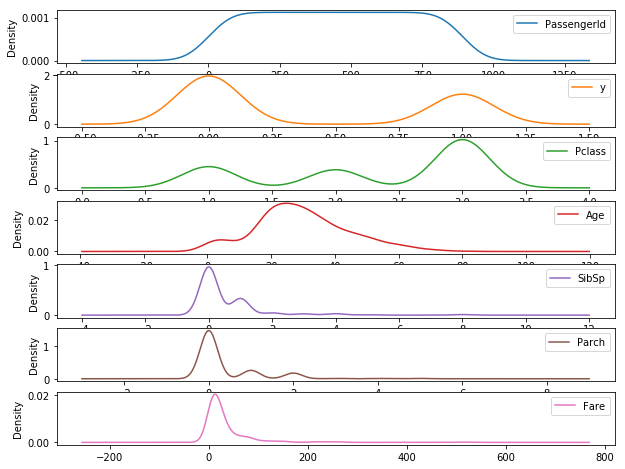

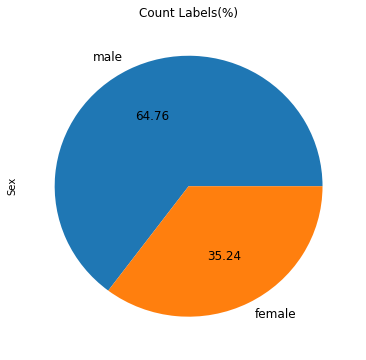

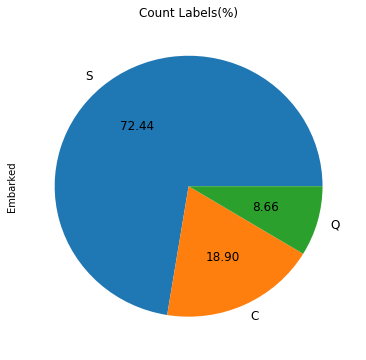

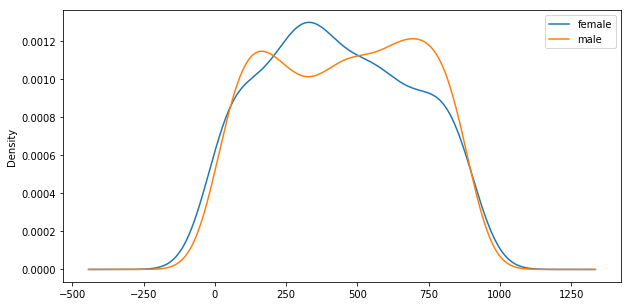

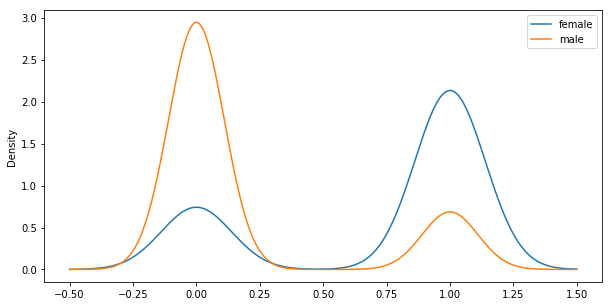

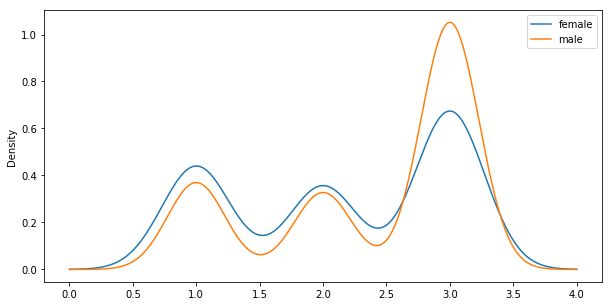

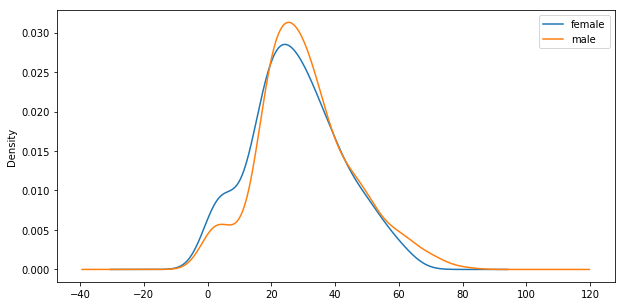

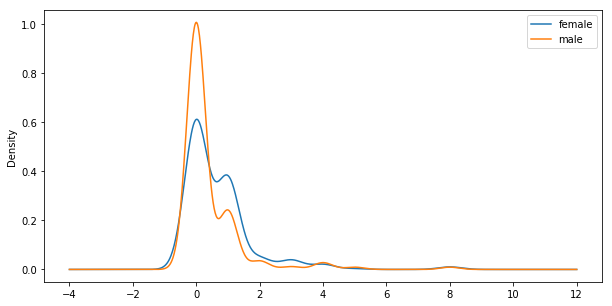

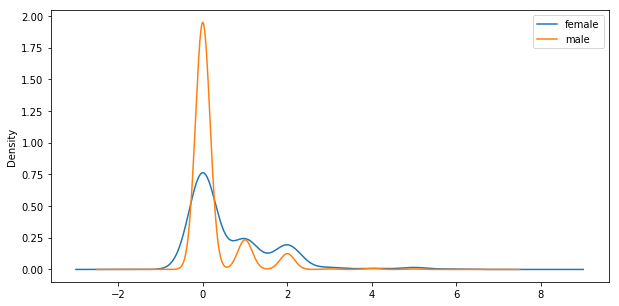

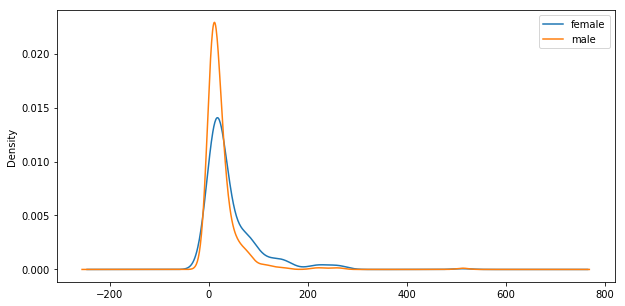

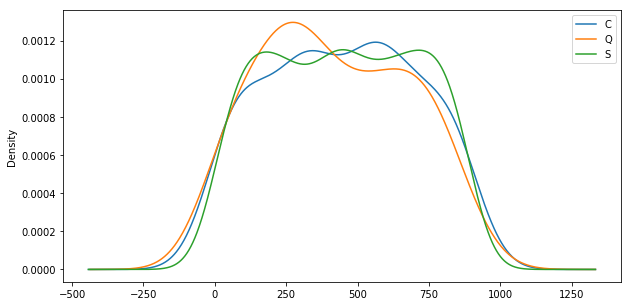

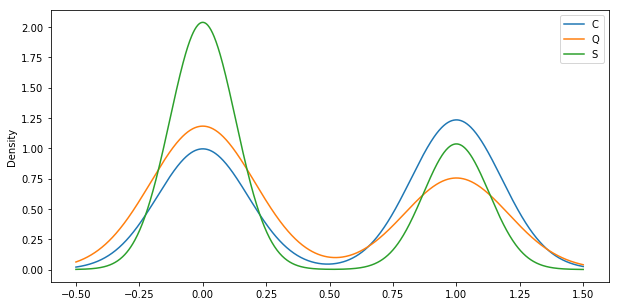

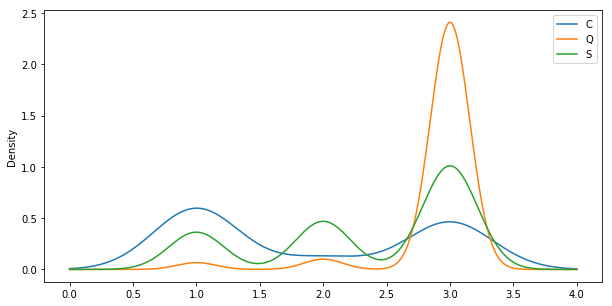

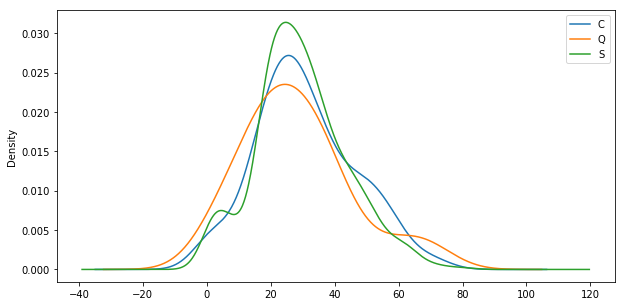

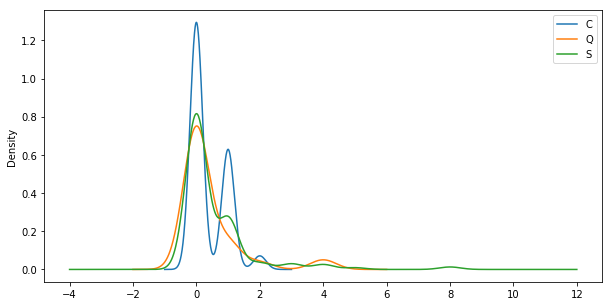

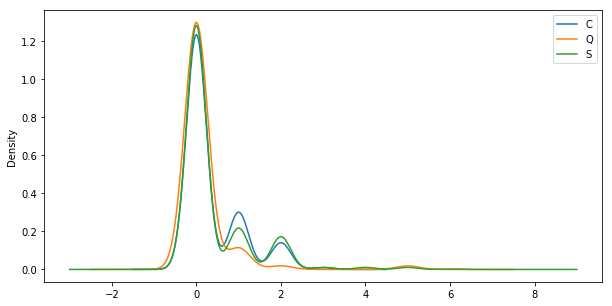

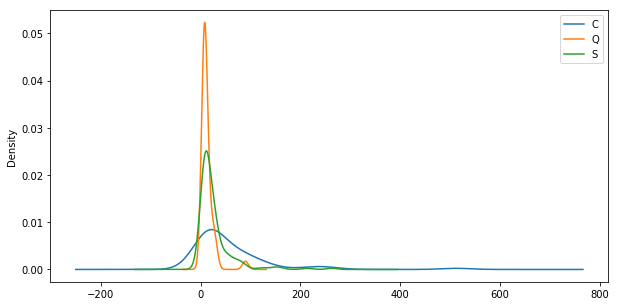

In [10]:
dfhist(dfdata)